In [ ]:
%pip install fasteda -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

In [ ]:
# import iris dataset from sklearn
from sklearn.datasets import fetch_openml

housing = fetch_openml(name="house_prices", as_frame=True)

# create a dataframe
df = housing.frame

# select 3 categorical and 3 numerical columns
df = df[['MSZoning', 'LotArea', 'GrLivArea', 'Street', 'Neighborhood', 'OverallQual', 'SalePrice']]

# randomly impute with null values except for SalePrice column
df = df.apply(lambda x: np.where(np.random.random(len(x)) < 0.1, np.nan, x) if x.name != 'SalePrice' else x)

In [ ]:
df.head()

,MSZoning,LotArea,GrLivArea,Street,Neighborhood,OverallQual,SalePrice
0,RL,8450.0,1710.0,NaN,CollgCr,7.0,208500.0
1,RL,9600.0,1262.0,Pave,Veenker,6.0,181500.0
2,RL,11250.0,1786.0,NaN,CollgCr,NaN,223500.0
3,RL,9550.0,1717.0,Pave,Crawfor,7.0,140000.0
4,RL,14260.0,2198.0,Pave,NoRidge,8.0,250000.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      1305 non-null   object 
 1   LotArea       1296 non-null   float64
 2   GrLivArea     1304 non-null   float64
 3   Street        1300 non-null   object 
 4   Neighborhood  1311 non-null   object 
 5   OverallQual   1310 non-null   float64
 6   SalePrice     1460 non-null   float64
dtypes: float64(4), object(3)
memory usage: 80.0+ KB


## missing cols

In [ ]:
null_cols = [i for i in df.columns if df[i].isna().sum() > 0]
df0 = df[null_cols]
null_cols

['MSZoning', 'LotArea', 'GrLivArea', 'Street', 'Neighborhood', 'OverallQual']

In [ ]:
display(
    df0.isna()
    .sum()
    .to_frame()
    .style.set_properties(
        **{
            "background-color": "#000000",
            "color": "#ff0000",
            "font-weight": "bold",
        }
    )
)

,0
MSZoning,155
LotArea,164
GrLivArea,156
Street,160
Neighborhood,149
OverallQual,150


## MSNO matrix

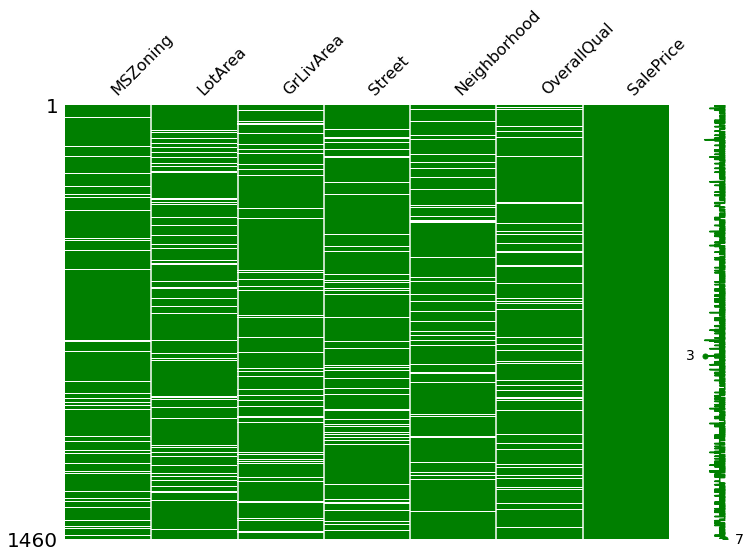

----------------------------------------------------------------------------------------------------


In [ ]:
import missingno as msno

msno.matrix(df, color=(0, 0.5, 0), figsize=(12, 8))
plt.show()
print("-" * 100)

## skew and kurtosis

In [ ]:
from scipy.stats import skew, kurtosis

skew_ = (
    df._get_numeric_data().dropna().apply(lambda x: skew(x)).to_frame(name="skewness")
)
kurt_ = (
    df._get_numeric_data()
    .dropna()
    .apply(lambda x: kurtosis(x))
    .to_frame(name="kurtosis")
)
skew_kurt = pd.concat([skew_, kurt_], axis=1)

skew_kurt

,skewness,kurtosis
LotArea,14.015951,285.397781
GrLivArea,1.354355,5.235581
OverallQual,0.173883,0.188880
SalePrice,1.939749,6.686896


In [ ]:
desc_df = df.describe().T

desc_df

,count,mean,std,min,25%,50%,75%,max
LotArea,1296.0,10391.294753,9462.923442,1300.0,7526.25,9410.5,11503.0,215245.0
GrLivArea,1304.0,1513.897239,516.073333,334.0,1134.00,1468.5,1774.0,5642.0
OverallQual,1310.0,6.098473,1.395808,1.0,5.00,6.0,7.0,10.0
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.00,163000.0,214000.0,755000.0


In [ ]:
full_info = pd.concat([desc_df, skew_kurt], ignore_index=True, axis=1)

full_info.columns = list(desc_df.columns) + list(skew_kurt.columns)
full_info.insert(
    loc=2, column="median", value=df.median(skipna=True, numeric_only=True)
)

full_info.iloc[:, :-2] = full_info.iloc[:, :-2].applymap(
    lambda x: format(x, ".3f").rstrip("0").rstrip(".")
    if isinstance(x, (int, float))
    else x
)

full_info

,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
LotArea,1296,10391.295,9410.5,9462.923,1300,7526.25,9410.5,11503,215245,14.015951,285.397781
GrLivArea,1304,1513.897,1468.5,516.073,334,1134,1468.5,1774,5642,1.354355,5.235581
OverallQual,1310,6.098,6,1.396,1,5,6,7,10,0.173883,0.188880
SalePrice,1460,180921.196,163000,79442.503,34900,129975,163000,214000,755000,1.939749,6.686896


In [ ]:
def color_negative_red(value):
    if value < 0:
        color = "#ff0000"
    elif value > 0:
        color = "#00ff00"
    else:
        color = "#FFFFFF"
    return "color: %s" % color


info_cols = ["skewness", "kurtosis"]

display(
    full_info.style.background_gradient(cmap="Spectral", subset=full_info.columns[:-2])
    .applymap(color_negative_red, subset=info_cols)
    .set_properties(
        **{"background-color": "#000000", "font-weight": "bold"},
        subset=info_cols,
    )
    .set_properties(**{"font-weight": "bold"}, subset=full_info.columns[:-2])
)

,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
LotArea,1296,10391.295,9410.5,9462.923,1300,7526.25,9410.5,11503,215245,14.015951,285.397781
GrLivArea,1304,1513.897,1468.5,516.073,334,1134,1468.5,1774,5642,1.354355,5.235581
OverallQual,1310,6.098,6,1.396,1,5,6,7,10,0.173883,0.188880
SalePrice,1460,180921.196,163000,79442.503,34900,129975,163000,214000,755000,1.939749,6.686896


## categorical and numerical

In [ ]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
 
print(f"{cat_cols=}")

# Catch variables that are numeric but have less than 15 classes 
num_but_cat = [
    col
    for col in df.columns
    if df[col].nunique() <= 15 and df[col].dtypes != "O"
]

print(f"{num_but_cat=}")

cat_cols = cat_cols + num_but_cat
print(f"{cat_cols=}")

# catch variables that are categorical but have an immeasurably large number of classes (>15 in this case)
cat_but_car = [
    col
    for col in df.columns
    if df[col].nunique() > 15 and df[col].dtypes == "O"
]

print(f"{cat_but_car=}")

cat_cols = [col for col in cat_cols if col not in cat_but_car]
print(f"{cat_cols=}")

cat_cols=['MSZoning', 'Street', 'Neighborhood']
num_but_cat=['OverallQual']
cat_cols=['MSZoning', 'Street', 'Neighborhood', 'OverallQual']
cat_but_car=['Neighborhood']
cat_cols=['MSZoning', 'Street', 'OverallQual']


In [ ]:
num_cols = [col for col in df.columns if df[col].dtypes != "O"]

# Catch variables that are numeric but have less than 15 classes 
num_but_cat = [
    col
    for col in df.columns
    if df[col].nunique() <= 15 and df[col].dtypes != "O"
]

num_cols = [col for col in num_cols if col not in num_but_cat]
num_cols

['LotArea', 'GrLivArea', 'SalePrice']

## correlation

In [ ]:
df.columns.nunique()

7

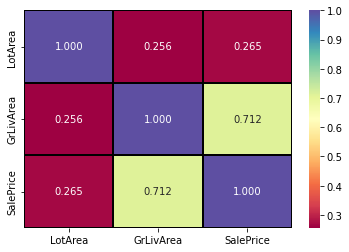

In [ ]:
import seaborn as sns
sns.heatmap(
    df[num_cols].corr(),
    annot=True,
    cmap="Spectral",
    linewidths=2,
    linecolor="#000000",
    fmt=".3f",
);

## all together

DataFrame Head:


,MSZoning,LotArea,GrLivArea,Street,Neighborhood,OverallQual,SalePrice
0,RL,8450.0,1710.0,NaN,CollgCr,7.0,208500.0
1,RL,9600.0,1262.0,Pave,Veenker,6.0,181500.0
2,RL,11250.0,1786.0,NaN,CollgCr,NaN,223500.0


DataFrame Tail:


,MSZoning,LotArea,GrLivArea,Street,Neighborhood,OverallQual,SalePrice
1457,RL,9042.0,NaN,Pave,Crawfor,7.0,266500.0
1458,RL,9717.0,1078.0,Pave,NAmes,5.0,142125.0
1459,RL,9937.0,1256.0,Pave,Edwards,5.0,147500.0


----------------------------------------------------------------------------------------------------
Missing values:


,0
MSZoning,155
LotArea,164
GrLivArea,156
Street,160
Neighborhood,149
OverallQual,150


----------------------------------------------------------------------------------------------------
MSNO Matrix:



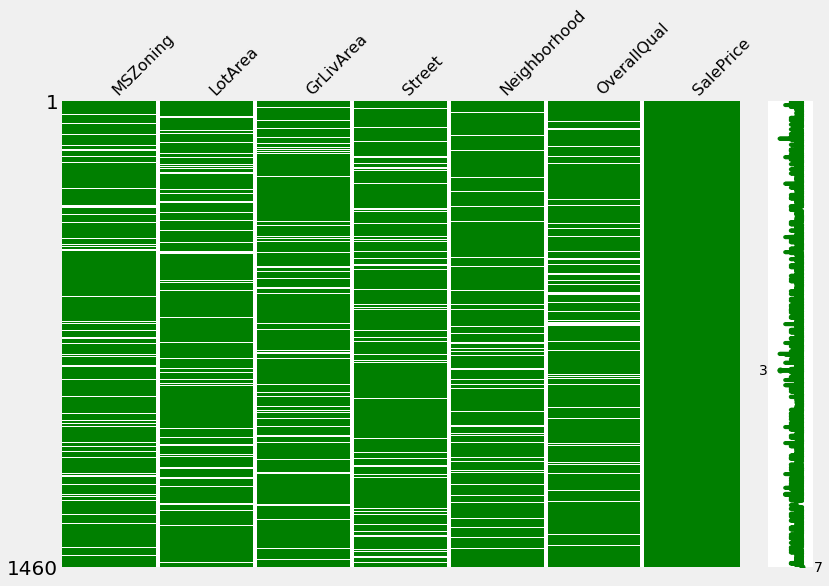

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(1460, 7)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      1305 non-null   object 
 1   LotArea       1296 non-null   float64
 2   GrLivArea     1304 non-null   float64
 3   Street        1300 non-null   object 
 4   Neighborhood  1311 non-null   object 
 5   OverallQual   1310 non-null   float64
 6   SalePrice     1460 non-null   float64
dtypes: float64(4), object(3)
memory usage: 80.0+ KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
LotArea,1296,10391.295,9410.5,9462.923,1300,7526.25,9410.5,11503,215245,14.015951,285.397781
GrLivArea,1304,1513.897,1468.5,516.073,334,1134,1468.5,1774,5642,1.354355,5.235581
OverallQual,1310,6.098,6,1.396,1,5,6,7,10,0.173883,0.188880
SalePrice,1460,180921.196,163000,79442.503,34900,129975,163000,214000,755000,1.939749,6.686896


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



/Users/benedictneo/miniforge3/lib/python3.9/site-packages/fasteda/__init__.py:168: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(),


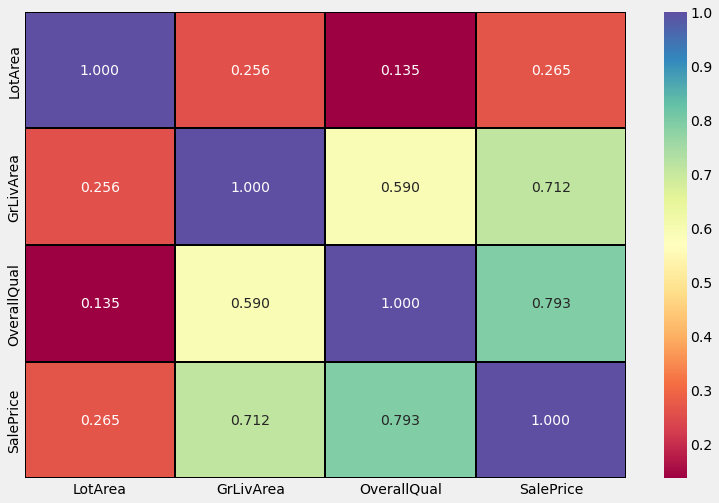

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



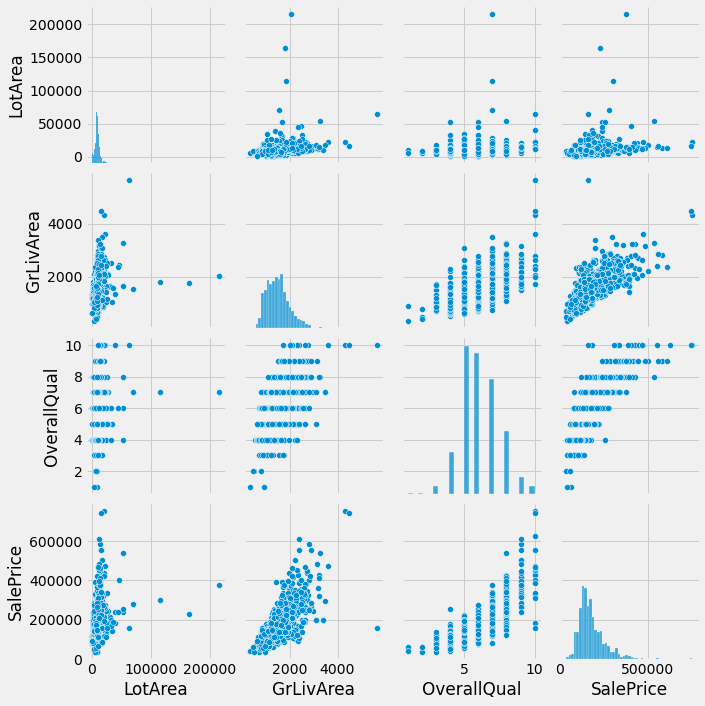

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



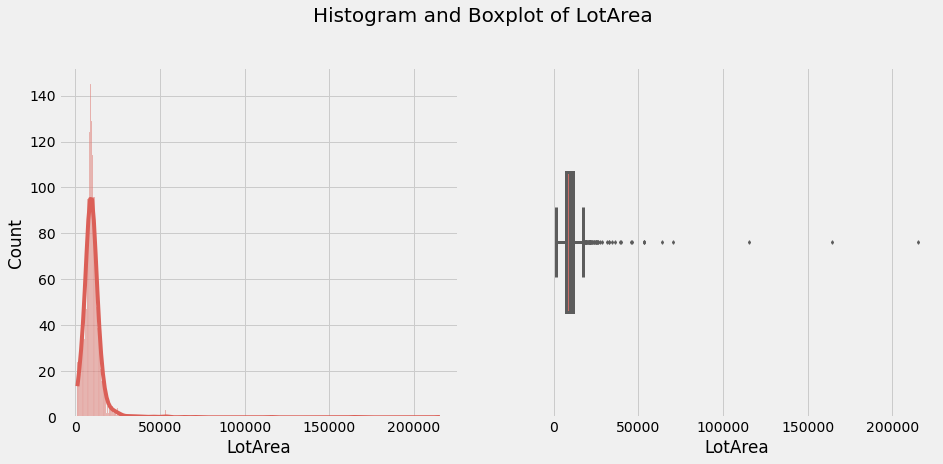

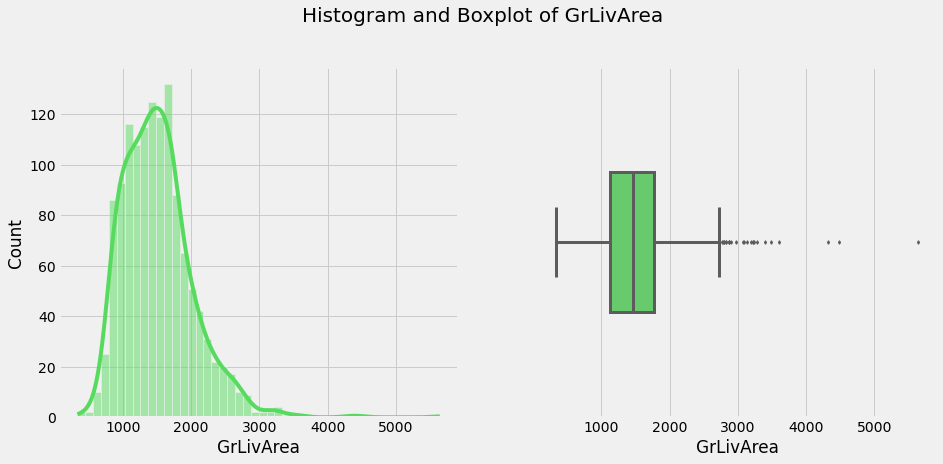

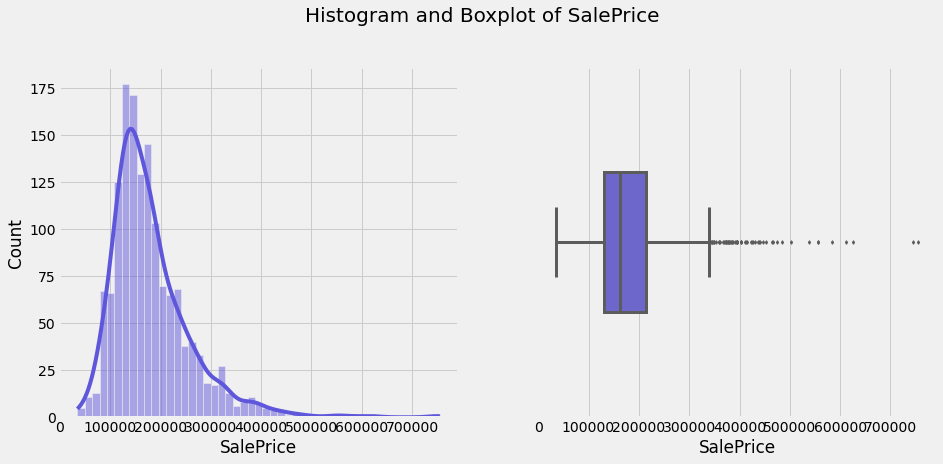

----------------------------------------------------------------------------------------------------
Countplot(s):



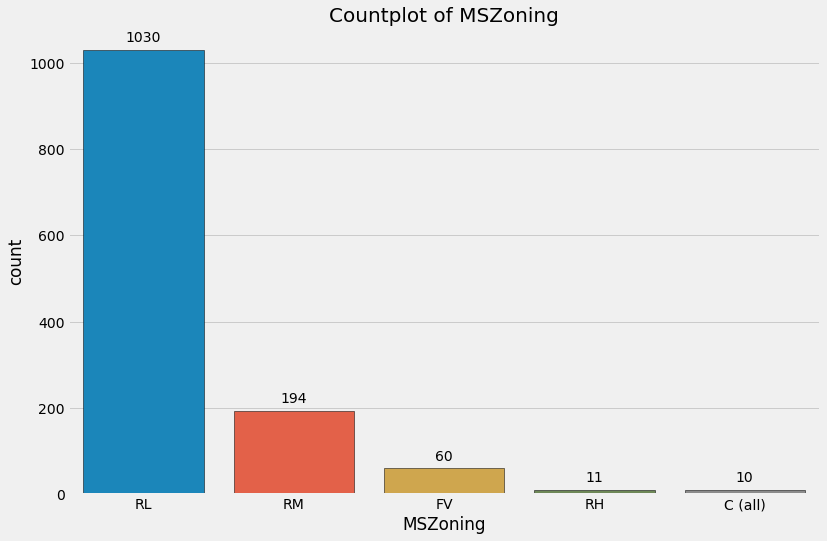

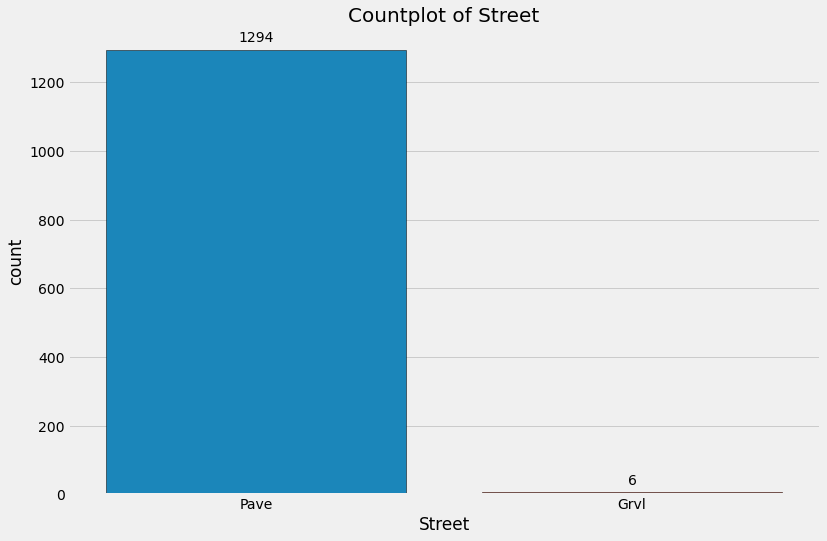

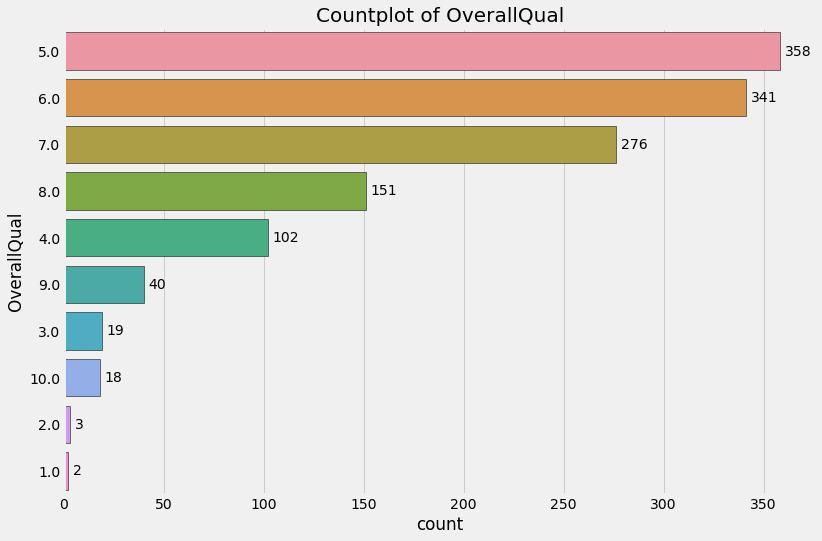

In [ ]:
from fasteda import fast_eda
fast_eda(df)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a605a3e6-1564-47b2-94e7-842290ba7692' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>